ReAct (Reasoning + Acting) is a framework where an LLM:

- make by create_react_agent
- doesnt need combinding llm to tools directly bcz retriever fun should convert to tools by a Tool lib

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import StructuredTool
from langchain_core.documents import Document
from langchain_core.tools import Tool
from pydantic import BaseModel, Field
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.document_loaders import WebBaseLoader, TextLoader, ArxivLoader
from langchain_community.vectorstores import FAISS
from typing import TypedDict, Annotated, Sequence
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages, BaseMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

True

In [132]:
# Math Functions
def add(a: int, b: int) -> int:
    """دو عدد را به هم اضافه کن a+b"""
    return a + b

def divide(a: float, b: float) -> float:
    """عدد اول را بر دمی تقسیم کن"""
    return a / b

def multiply(a: int, b: int) -> int:
    """دو عدد را ضرب کن"""
    return a * b

In [3]:
# Wiki tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2))

In [4]:
# Travily tool
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
Travily_tool = TavilySearchResults(
            max_results=3,
            include_answer=True,
            include_raw_content=True,
            include_images=True)

C:\Users\user\AppData\Local\Temp\ipykernel_24304\1335035453.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  Travily_tool = TavilySearchResults(


In [5]:
# web search 
# (perfume data & quotes) docs
urls = ["https://roozaneh.net/fashion-world/other/%D8%A7%D9%81%D8%B2%D8%A7%DB%8C%D8%B4-%D9%BE%D8%AE%D8%B4-%D8%A8%D9%88%DB%8C-%D8%B9%D8%B7%D8%B1/",
        "https://roozaneh.net/fun/sms/%D8%AC%D9%85%D9%84%D8%A7%D8%AA-%D8%B2%DB%8C%D8%A8%D8%A7/"]
loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://roozaneh.net/fashion-world/other/%D8%A7%D9%81%D8%B2%D8%A7%DB%8C%D8%B4-%D9%BE%D8%AE%D8%B4-%D8%A8%D9%88%DB%8C-%D8%B9%D8%B7%D8%B1/', 'title': '۶ روش برای افزایش پخش بوی عطر و ماندگاری رایحه', 'description': 'افزایش پخش بوی عطر فقط به خرید یک شیشه گران قیمت محدود نمی شود؛ راز ماندگاری رایحه در ترکیبی هوشمندانه از انتخاب عطر، شیوه صحیح استفاده و حتی نحوه نگهداری آن', 'language': 'fa-IR'}, page_content=' ۶ روش برای افزایش پخش بوی عطر و ماندگاری رایحه     روزانهجملاتشعربیوگرافیکتابسینماگردشگریسلامتزیباییآشپزیتکنولوژیجستجوروزانه » گوناگون۶ روش برای افزایش پخش بوی عطر و ماندگاری رایحهافزایش پخش بوی عطر فقط به خرید یک شیشه گران قیمت محدود نمی شود؛ راز ماندگاری رایحه در ترکیبی هوشمندانه از انتخاب عطر، شیوه صحیح استفاده و حتی نحوه نگهداری آن نهفته است. نوع پوست، ساختار نت های عطر و شرایط محیطی می توانند یک رایحه معمولی را به عطری اثرگذار تبدیل کنند. در این مطلب، مهم ترین عوامل و روش های کاربردی برای تقویت پخش بو و دوام عطر را بررسی می کنیم تا انتخابی آگاهانه 

In [6]:
# Splitting & Embedding
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = text_splitter.split_documents(docs)

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
vectorstore = FAISS.from_documents(texts, embedding_model)
retriever = vectorstore.as_retriever(
        search_type="similarity", # ('similarity', 'similarity_score_threshold', 'mmr')
        search_kwargs={"k":3})
        

In [22]:
embed = retriever.invoke("جمله انگیزشی")
print(embed)

[Document(id='ef11bbe5-f333-4441-9428-2cdc68d8c4ab', metadata={'source': 'https://roozaneh.net/fun/sms/%D8%AC%D9%85%D9%84%D8%A7%D8%AA-%D8%B2%DB%8C%D8%A8%D8%A7/', 'title': 'جملات زیبا + متن های زیبا و دلنشین با موضوعات مختلف و جالب با 100 جمله', 'description': 'در این بخش جملات زیبا و دلنشینی را گردآوری کرده ایم که حس مثبتی را به شما منتقل می کنند و دارای مضامینی مانند زندگی، انگیزش و موفقیت هستند.', 'language': 'fa-IR'}, page_content='تبریک حسابدار به خودم (متن و جملات انگیزشی تبریک روز حسابدار به خود)\nمتن پرواز کن با رویاهات { خاص ترین جملات انگیزشی کوتاه }\nجملات سایمون سینک نویسنده و مشاور با سخنان انگیزشی قدرتمند\nبیو برای واتساپ | متن کوتاه بیو با معنی | جملات احساسی و انگیزشی Bio\nمتن انگیزشی طبیعت و جملات خاص در مورد زیبایی های بی نظیر طبیعت\nجملات صبح بخیر انگیزشی برای استوری؛ متن های صبحت بخیر با انرژی\nصبح بخیر انگیزشی تابستانی با جملات مثبت انرژی دهنده'), Document(id='4bc52184-f650-4ee0-8622-5cbae9633000', metadata={'source': 'https://roozaneh.net/fun/sms/%D8%AC%D9%85%D9%84

In [155]:
# Init State
class AgentState (BaseModel):
    question:str
    context:list[Document] = []
    answer:str = ""

In [156]:
# Retriever tool
def retriever_tool(state : AgentState) -> AgentState:
    context = retriever.invoke(state.question)
    return AgentState(question=state.question,context=context)

In [11]:
# Init llm 
groq_llm = ChatGroq(model="llama-3.1-8b-instant",api_key=os.getenv("GROQ_API"),temperature=0.2)

In [160]:
# Init Brain llm 
def Agent_brain(state:AgentState)-> AgentState:
    print(f"question recieved: {state.question} \nsearching for vectore store web search")
    
    context = "\n\n".join([doc.page_content for doc in state.context])
    prompt = f"Answer the user request based on the contexts.\n\nContexts:\n{context}\n\nQuestion: {state.question}"
    response = groq_llm.invoke(prompt)
    return AgentState(question=state.question, context=state.context, answer=response.content)

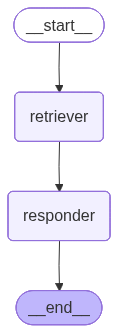

In [161]:
# Make langgraph
## Way 1 is sequential and just use web seach retriever
builder = StateGraph(AgentState)

builder.add_node("retriever", retriever_tool)
builder.add_node("responder", Agent_brain)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [162]:
if __name__ == "__main__":
    user_question = "یک جمله انگیزشی بگو"
    initial_state = AgentState(question=user_question)
    final_state = graph.invoke(initial_state)

    print(final_state['answer'])

question recieved: یک جمله انگیزشی بگو 
searching for vectore store web search
"تو در زندگی، قدرتمندترین شخص هستی. به خودت قول بده که هیچ نوع حال و هوای بدی را تحمل نکنی و فقط حال و هوای خوب را انتخاب کنی."


## Way 2 : reAct among 5 different tools

In [164]:
def retriever_tool_node(query: str) -> str:
    print("Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [140]:
@tool
def RAGRetriever(query: str) -> str:
    """Fetch relevant knowledge base info."""
    print("Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join(doc.page_content for doc in docs)

In [179]:
# Make retriever as a tool and model in create_react_agent
retriever_tool=Tool(
    name="RAGRetriever",
    # description="ONLY use this tool for factual lookup.Its a retriever for perfume info and quotes. DO NOT use for math or simple questions.", # so important model decide and think base on this. we are making sth like llm.binding
    description="فقط از این ابزار برای جستجوی اطلاعات واقعی استفاده کنید. این یک ابزار بازیابی برای اطلاعات عطر و نقل قول‌ها است. برای ریاضی یا سوالات ساده از آن استفاده نکنید.",
    func=retriever_tool_node
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [170]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

C:\Users\user\AppData\Local\Temp\ipykernel_24304\1098087524.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(groq_llm,tools) # it has memory


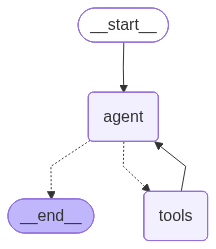

In [180]:
tools = [retriever_tool, wiki_tool,add,divide,multiply]

## create the native Langgraph react agent
react_node=create_react_agent(groq_llm,tools) # it has memory
react_node

In [181]:
# limiting routes
def route_llm(state):
    last = state["messages"][-1]

    if last.tool_calls:
        return "tools"

    return END


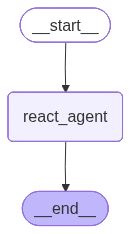

In [182]:
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)
# builder.add_conditional_edges("react_agent",route_llm,{"tools": "tools", END: END})
graph = builder.compile()
graph

In [177]:
if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(user_query)]}
    result = graph.invoke(state)

    print(f"question recieved: {user_query} searching for best tools \namong: \n1.mathematics \n2.perfume data \n3.quotes\n4.wikipedia \n5.latest web search\n", result["messages"][-1].content) # 

question recieved: What is an agent loop and how does Wikipedia describe autonomous agents? searching for best tools 
among: 
1.mathematics 
2.perfume data 
3.quotes
4.wikipedia 
5.latest web search
 The agent loop is a concept in artificial intelligence where an agent is caught in a time loop, causing it to repeat the same actions over and over. This can be seen in the TV show Agents of S.H.I.E.L.D. in the episode "As I Have Always Been", where the Life Model Decoy (LMD) of Phil Coulson and his team are caught in a time storm, causing a time loop.

Autonomous agents are entities that perceive their environment, take actions autonomously to achieve goals, and may improve their performance through machine learning or by acquiring knowledge. They can range from simple to highly complex and are often described schematically as abstract functional systems similar to computer programs.

The study of autonomous agents and multi-agent systems is covered by the journal Autonomous Agents and Mu

In [186]:
if __name__ == "__main__":
    user_query = "جمع 5 با 8 چند میشه"
    state = {"messages": [HumanMessage(user_query)]}
    result = graph.invoke(state)

    print(f"question recieved: {user_query} searching for best tools \namong: \n1.mathematics \n2.perfume data \n3.quotes\n4.wikipedia \n5.latest web search\n", result["messages"][-1].content) # 

question recieved: جمع 5 با 8 چند میشه searching for best tools 
among: 
1.mathematics 
2.perfume data 
3.quotes
4.wikipedia 
5.latest web search
 این جواب درستی نیست. جواب درست این است که 5 + 8 = 13


####  Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [50]:
### Generic function to create a retireval tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, embedding_model)
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


# Wikipedia Tool
# wiki_tool = Tool(
#     name="Wikipedia",
#     description="Use this tool to fetch general world knowledge from Wikipedia.",
#     func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2)).run
# )
wiki_api = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2))
def wiki_search_wrapper(query: str) -> str:
    """Fetches information from Wikipedia."""
    return wiki_api.run(query)

wiki_tool = Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from Wikipedia.",
    func=wiki_search_wrapper  # Pass the wrapper, not the raw .run method
)
# ArXiv Tool
def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
)


In [62]:
wiki_api = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2))
class WikiInput(BaseModel):
    query: str = Field(description="The topic to search on Wikipedia")

def wiki_search_wrapper(query: str) -> str:
    return wiki_api.run(query)

wiki_tool = StructuredTool.from_function(
    func=wiki_search_wrapper,
    name="Wikipedia",
    description="Fetch general world knowledge from Wikipedia.",
    args_schema=WikiInput
)

# --- 2. ArXiv Tool (Wrapped as StructuredTool) ---
class ArxivInput(BaseModel):
    query: str = Field(description="The academic paper topic to search for")

def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    try:
        results = ArxivLoader(query=query, load_max_docs=2).load()
        return "\n\n".join(doc.page_content[:1000] for doc in results) or "No papers found."
    except Exception as e:
        return f"Error: {e}"

arxiv_tool = StructuredTool.from_function(
    func=arxiv_search,
    name="ArxivSearch",
    description="Fetch recent academic papers on technical topics.",
    args_schema=ArxivInput
)

# --- 3. Generic Retriever Factory (Fixed) ---
def make_retriever_tool_from_text(file, name, desc):
    # Ensure file loading works (added simple error handling for path issues)
    try:
        docs = TextLoader(file, encoding="utf-8").load()
    except Exception as e:
        print(f"⚠️ Could not load {file}: {e}")
        return None # Or handle gracefully
        
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, embedding_model)
    retriever = vs.as_retriever()

    class RetrieverInput(BaseModel):
        query: str = Field(description="The query string to search for in the documents")

    def tool_func(query: str) -> str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return StructuredTool.from_function(
        func=tool_func,
        name=name,
        description=desc,
        args_schema=RetrieverInput
    )

In [63]:
internal_tool_1=make_retriever_tool_from_text(
    "G://extracted//ML//RAG//AgenticRAG//sample-docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

StructuredTool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', args_schema=<class '__main__.make_retriever_tool_from_text.<locals>.RetrieverInput'>, func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000002A505773240>)

In [64]:
internal_tool_2 = make_retriever_tool_from_text(
    "G://extracted//ML//RAG//AgenticRAG//research-notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

StructuredTool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', args_schema=<class '__main__.make_retriever_tool_from_text.<locals>.RetrieverInput'>, func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000002A4F455D300>)

C:\Users\user\AppData\Local\Temp\ipykernel_10008\2036321237.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(groq_llm,tools)


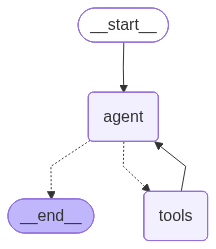

In [65]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node=create_react_agent(groq_llm,tools)
react_node

In [66]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

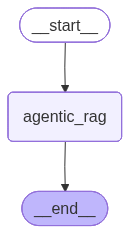

In [67]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph


In [68]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using tool: InternalResearchNotes
🧪 Searching ArXiv...
🧪 Searching ArXiv...

✅ Final Answer:
 It seems like the ArxivSearch function is not working due to a missing package. Let's try to search ArXiv manually.

Recent papers on transformer variants:

1. "Efficient Transformers for Question Answering" by Google Research (2022)
   - Introduces a new transformer architecture for question answering tasks
   - Achieves state-of-the-art results on several benchmarks

2. "Longformer: The Long-Document Transformer" by Facebook AI (2020)
   - Proposes a new transformer architecture for handling long documents
   - Evaluates on several natural language processing tasks

3. "TinyBERT: Distilling BERT for Natural Language Understanding" by Microsoft Research (2020)
   - Presents a method for distilling BERT into a smaller model
   - Evaluates on several natural language understanding tasks

4. "FlashAttention: Fast and Memory-Efficient Attention Mechanisms" by Google Research (2022)
   - Introdu

## StructuredTool 👌
- **better way among @tool or Tool lib**

What is a “Structured Tool”?
A structured tool represents an action an agent can take. It wraps any function you provide to let an agent easily interface with it. A Structured Tool object is defined by its:

name: a label telling the agent which tool to pick. For example, a tool named "GetCurrentWeather" tells the agent that it's for finding the current weather.
description: a short instruction manual that explains when and why the agent should use the tool.
args_schema: Communicates the interface of the tool for the agent. It typically draws from the wrapped function's signature and permits additional validation logic on tool inputs.
_run and _arun functions: These define the tool's inner workings. It could be something simple like returning the current time or more complex like sending a message or controlling a robot.
The tool name is its unique identifier. A good name unambiguously communicates what it does, so a tool called “GetCurrentWeather” is much more useful than “GCTW” . If a tool’s name isn’t clear to you, it probably isn’t clear to the agent either. If you are giving an agent access to multiple tools, the name could also provide information about their relationship. For instance, if you have “AmazonSearch” and “AmazonCurrentBalance” and “NikeShoppingCart” tools, the agent can infer that the first two are related, even without reading the description.

The description provides more detailed directives on how to use the tool. A good description is concise but effectively communicates what the tool does. This can also provide space to provide short examples (or counter examples) if needed.

The args_schema is a Pydantic BaseModel that defines the arguments (along with their type information) that are to be fed to the tool. It has two main jobs: first, to communicate what information is required from the agent. The second job is to validate those inputs before executing the tool's inner functionality.

Finally, the _run and accompanying async _arun methods define tool’s logic. You can put anything here, from arithmetic, to API requests, to calls to other LLM Chains.